# Getting started with Linear regression

MLJ essentially serves as a unified path to many existing Julia packages each of which provides their own functionalities and models, with their own conventions.
The simple linear regression demonstrates this. Several packages offer it (beyond just using the backslash operator): here we will use MLJLinearModels but we could also have used GLM, ScikitLearn etc.

- To load the model from a given package use @load ModelName pkg=PackageName
- Run `import Pkg; Pkg.add("MLJ")` to install the MLJ package.

In [1]:
using MLJ

@load LinearRegressor pkg=MLJLinearModels

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/h62343la/.julia/packages/MLJModels/Ppopl/src/loading.jl:168


import MLJLinearModels ✔


MLJLinearModels.LinearRegressor

In [2]:
import RDatasets: dataset
import DataFrames: describe, select, Not, rename!
boston = dataset("MASS", "Boston")
first(boston, 3)

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242


Let's get a feel for the data

In [3]:
describe(boston, :mean, :std, :eltype)

,variable,mean,std,eltype
,Symbol,Float64,Float64,DataType
1,Crim,3.61352,8.60155,Float64
2,Zn,11.3636,23.3225,Float64
3,Indus,11.1368,6.86035,Float64
4,Chas,0.06917,0.253994,Int64
5,NOx,0.554695,0.115878,Float64
6,Rm,6.28463,0.702617,Float64
7,Age,68.5749,28.1489,Float64
8,Dis,3.79504,2.10571,Float64
9,Rad,9.54941,8.70726,Int64


So there's no missing value and most variables are encoded as floating point numbers. In MLJ it's important to specify the interpretation of the features (should it be considered as a Continuous feature, as a Count, ...?), see also this tutorial section on scientific types.

Here we will just interpret the integer features as continuous as we will just use a basic linear regression:


In [4]:
data = coerce(boston, autotype(boston, :discrete_to_continuous));

Let's also extract the target variable (MedV):

In [5]:
y = data.MedV
X = select(data, Not(:MedV));

Let's declare a simple multivariate linear regression model:

In [6]:
model = MLJLinearModels.LinearRegressor()

LinearRegressor(
    fit_intercept = true,
    solver = nothing) @543

First let us do a very simple univariate regression, in order to fit it on the data, we need to wrap it in a machine which, in MLJ, is the composition of a model and data to apply the model on:


In [7]:
X_uni = select(X, :LStat) # only a single feature
mach_uni = machine(model, X_uni, y)
fit!(mach_uni)

┌ Info: Training Machine{LinearRegressor,…} @442.
└ @ MLJBase /Users/h62343la/.julia/packages/MLJBase/diSrF/src/machines.jl:354


Machine{LinearRegressor,…} @442 trained 1 time; caches data
  args: 
    1:	Source @541 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @153 ⏎ `AbstractVector{Continuous}`


You can then retrieve the fitted parameters using fitted_params:

In [8]:
fp = fitted_params(mach_uni)
@show fp.coefs
@show fp.intercept

fp.coefs = [:LStat => -0.950049353757991]
fp.intercept = 34.553840879383095


34.553840879383095

Let's try to visualise this

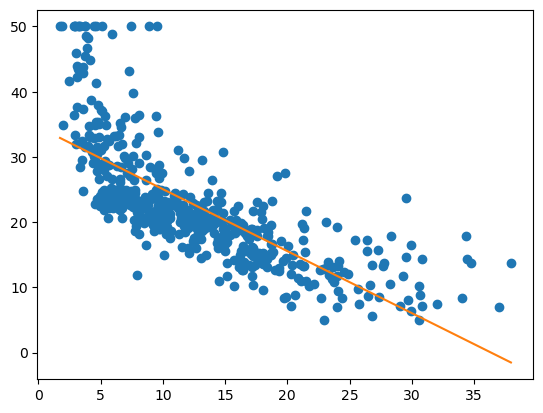

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc9aedec850>

In [13]:
using PyPlot

#figure(figsize=(8,6))
PyPlot.plot(X.LStat, y, ls="none", marker="o")
Xnew = (LStat = collect(range(extrema(X.LStat)..., length=100)),)
PyPlot.plot(Xnew.LStat, predict(mach_uni, Xnew))

The multivariate case is very similar

In [11]:
mach = machine(model, X, y)
fit!(mach)

fp = fitted_params(mach)
coefs = fp.coefs
intercept = fp.intercept
for (name, val) in coefs
    println("$(rpad(name, 8)):  $(round(val, sigdigits=3))")
end
println("Intercept: $(round(intercept, sigdigits=3))")

┌ Info: Training Machine{LinearRegressor,…} @426.
└ @ MLJBase /Users/h62343la/.julia/packages/MLJBase/diSrF/src/machines.jl:354


Crim    :  -0.108
Zn      :  0.0464
Indus   :  0.0206
Chas    :  2.69
NOx     :  -17.8
Rm      :  3.81
Age     :  0.000692
Dis     :  -1.48
Rad     :  0.306
Tax     :  -0.0123
PTRatio :  -0.953
Black   :  0.00931
LStat   :  -0.525
Intercept: 36.5


You can use the machine in order to predict values as well and, for instance, compute the root mean squared error:

In [14]:
ŷ = predict(mach, X)
round(rms(ŷ, y), sigdigits=4)

4.679

Let's see what the residuals look like

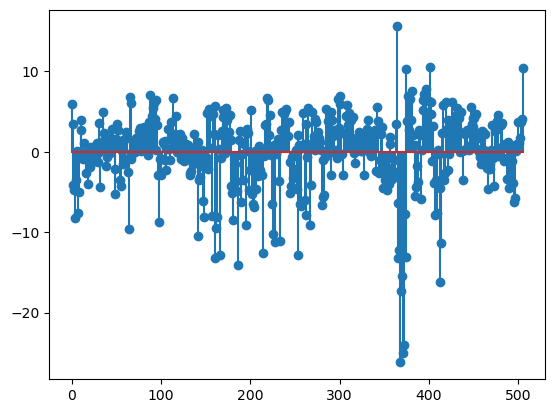

(PyObject <matplotlib.lines.Line2D object at 0x7fc9a9fba2b0>, PyObject <matplotlib.collections.LineCollection object at 0x7fc9a9faac70>, PyObject <matplotlib.lines.Line2D object at 0x7fc9a9fba610>)

In [15]:
using PyPlot
#figure(figsize=(8,6))
res = ŷ .- y
stem(res)

Maybe that a histogram is more appropriate here

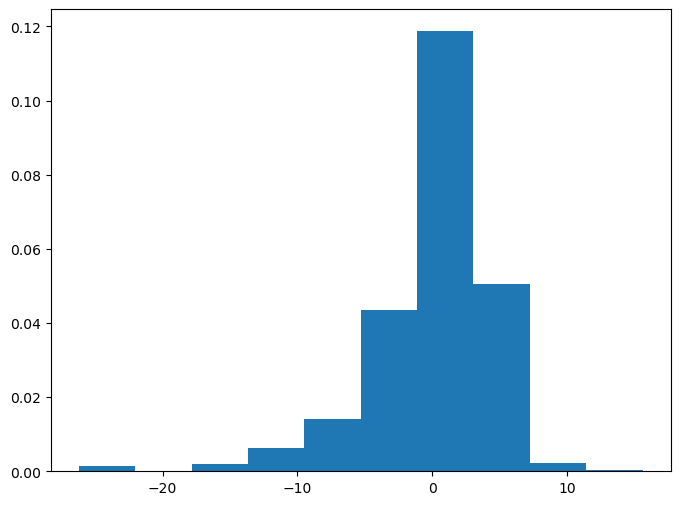

([0.0014185983506153493, 0.0, 0.0018914644674871341, 0.006147259519333181, 0.014185983506153493, 0.04350368275220408, 0.11868939533481757, 0.05059667450528079, 0.002364330584358916, 0.00047286611687178315], [-26.19927097790839, -22.019896490148035, -17.84052200238768, -13.661147514627327, -9.481773026866971, -5.3023985391066155, -1.1230240513462633, 3.0563504364140925, 7.235724924174448, 11.415099411934804, 15.59447389969516], (PyObject <matplotlib.patches.Rectangle object at 0x7fc9ac7016d0>, PyObject <matplotlib.patches.Rectangle object at 0x7fc9ac701550>, PyObject <matplotlib.patches.Rectangle object at 0x7fc9ac701bb0>, PyObject <matplotlib.patches.Rectangle object at 0x7fc9ac701e80>, PyObject <matplotlib.patches.Rectangle object at 0x7fc9ac70e190>, PyObject <matplotlib.patches.Rectangle object at 0x7fc9ac70e460>, PyObject <matplotlib.patches.Rectangle object at 0x7fc9ac70e730>, PyObject <matplotlib.patches.Rectangle object at 0x7fc9ac70ea00>, PyObject <matplotlib.patches.Rectangle o

In [18]:
PyPlot.figure(figsize=(8,6))
hist(res, density=true)

# Interaction and transformation


Let's say we want to also consider an interaction term of lstat and age taken together. 
- To do this, just create a new dataframe with an additional column corresponding to the interaction term:

In [19]:
X2 = hcat(X, X.LStat .* X.Age);

In [20]:
rename!(X2, :x1 => :interaction);

Let's fit the linear regression, again.

In [22]:
mach = machine(model, X2, y)
fit!(mach)
ŷ = predict(mach, X2)
round(rms(ŷ, y), sigdigits=4)

┌ Info: Training Machine{LinearRegressor,…} @619.
└ @ MLJBase /Users/h62343la/.julia/packages/MLJBase/diSrF/src/machines.jl:354


4.676

In [23]:
X3 = hcat(X.LStat, X.LStat.^2)
mach = machine(model, X3, y)
fit!(mach)
ŷ = predict(mach, X3)
round(rms(ŷ, y), sigdigits=4)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=LinearRegressor @543`:
│ scitype(X) = AbstractMatrix{Continuous}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:(AbstractVector{var"#s9"} where var"#s9"<:Continuous).
└ @ MLJBase /Users/h62343la/.julia/packages/MLJBase/diSrF/src/machines.jl:103
┌ Info: Training Machine{LinearRegressor,…} @803.
└ @ MLJBase /Users/h62343la/.julia/packages/MLJBase/diSrF/src/machines.jl:354


5.507

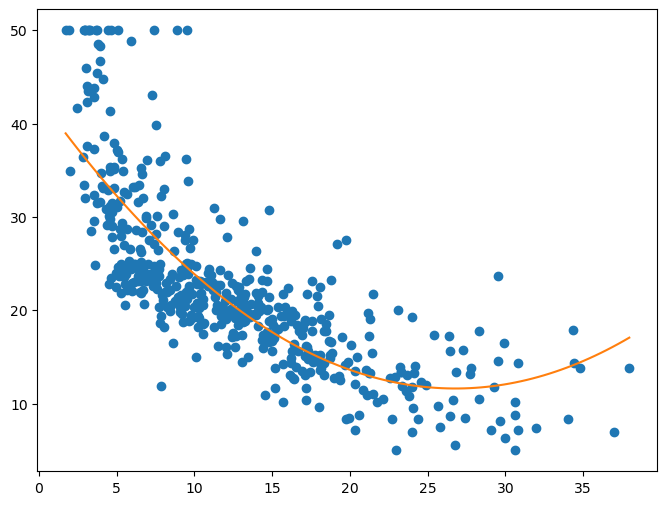

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc9af092ee0>

In [24]:
Xnew = (LStat = Xnew.LStat, LStat2 = Xnew.LStat.^2)

PyPlot.figure(figsize=(8,6))
PyPlot.plot(X.LStat, y, ls="none", marker="o")
PyPlot.plot(Xnew.LStat, predict(mach, Xnew))